# Peer-graded Assignment: Анализ данных в задаче кредитного скоринга

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
sns.set(rc={'figure.figsize': (20, 10)})

In [4]:
data = pd.read_csv('credit_card_default_analysis.csv', index_col=0)
data.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
ID,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


**Задание 1.**
Размер кредитного лимита (LIMIT_BAL). В двух группах, тех людей, кто вернул кредит (default = 0) и тех, кто его не вернул (default = 1) проверьте гипотезы:
- a) о равенстве медианных значений кредитного лимита с помощью подходящей интервальной оценки
- b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

Разобьём данные на должников и вернувших кредит, возьмём данные по размеру кредитного лимита и посмотрим на распределение.


In [5]:
limit_debtor_data = data[data.default == 1].loc[:, 'LIMIT_BAL']
limit_paid_data = data[data.default == 0].loc[:, 'LIMIT_BAL']

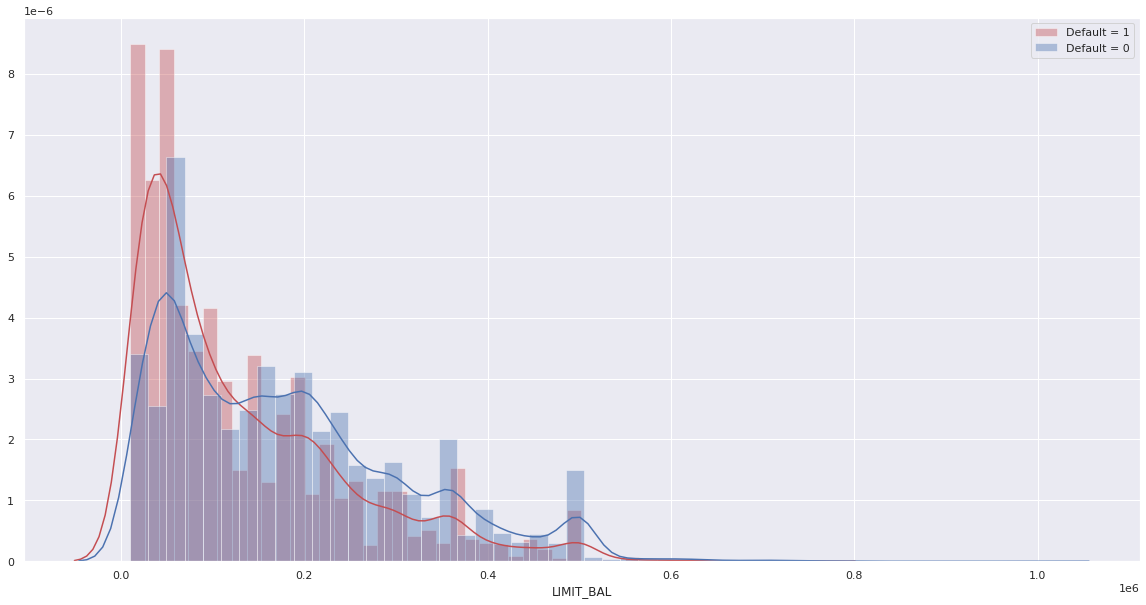

In [6]:
sns.distplot(limit_debtor_data, color='r', label='Default = 1')
sns.distplot(limit_paid_data, color='b', label='Default = 0')
plt.legend();

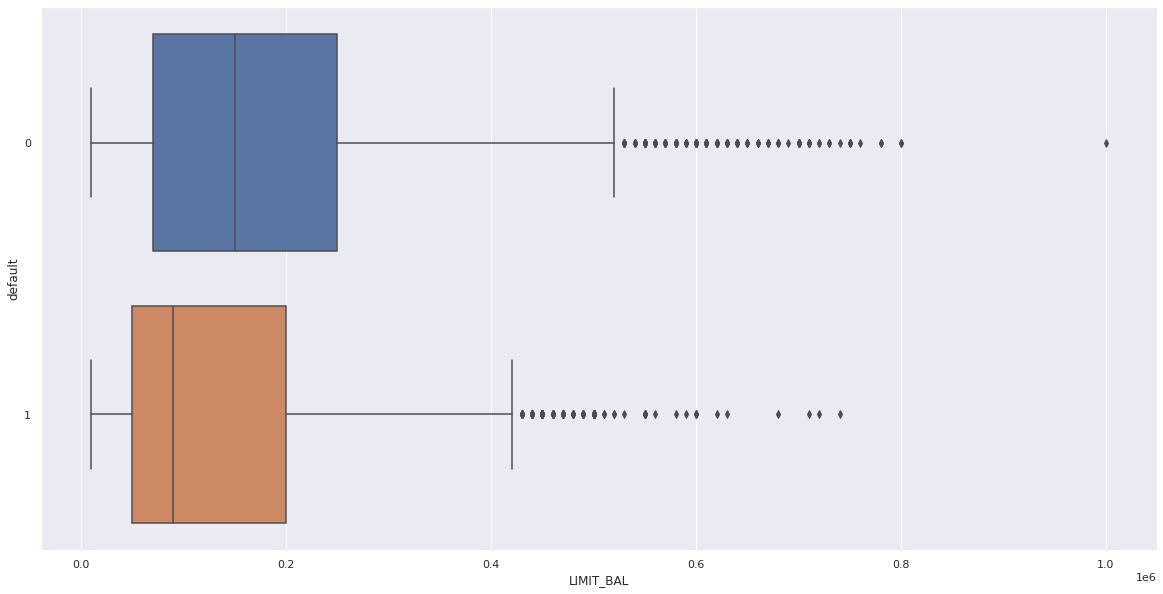

In [7]:
sns.boxplot(data.LIMIT_BAL, data.default, orient='h');

По графикам видно, что распределение признака не является нормальным, а имеет длинный правый хвост в обеих группах. Также люди, которые кредит вернули, похоже имеют больше доверия у банка, так как размер их кредитного лимита в основном больше, чем у должников. У многих должников размер кредитного лимита очень близок к нулю. 

Чтобы проверить равенство медианных значений кредитного лимита с помощью интервальной оценки воспользуемся методом бутстрэпа.

In [8]:
def get_bootstrap_samples(data, n_samples):
    return np.random.choice(data, size=[n_samples, len(data)], replace=True)

In [9]:
def get_interval(data, alpha=0.05):
    return np.percentile(data, [100 * alpha / 2, 100 * (1 - alpha / 2)])

In [10]:
# Получаем бутстрэп сэмплы из данных обеих групп и считаем медианы
np.random.seed(42)
n_samples = 1000
bootstrap_debtor_medians = np.median(get_bootstrap_samples(limit_debtor_data, n_samples), axis=1)
bootstrap_paid_medians = np.median(get_bootstrap_samples(limit_paid_data, n_samples), axis=1)

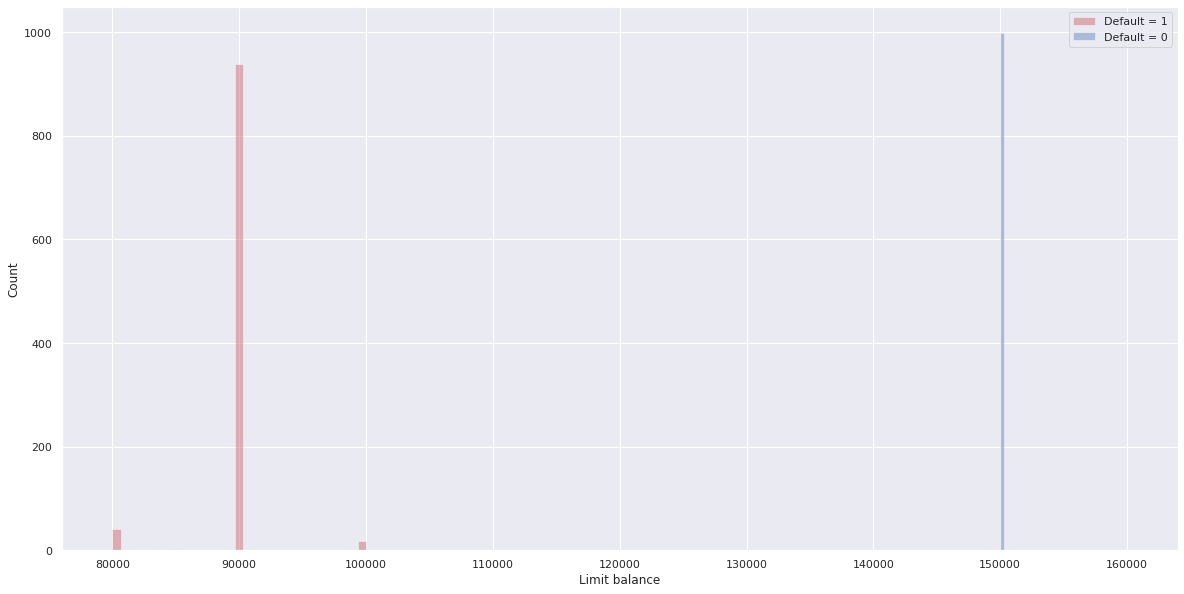

In [11]:
# Посмотрим на распределение медиан
sns.distplot(bootstrap_debtor_medians, kde=False, color='r', label='Default = 1')
sns.distplot(bootstrap_paid_medians, kde=False, color='b', label='Default = 0')
plt.xlabel('Limit balance')
plt.ylabel('Count')
plt.legend();

Видим, что большинство значений медианы кредитного лимита для должников лежит около 90000, тогда как для вернувших кредит большинство значений лежит в районе 150000.

Будем проверять нулевую гипотезу о том, что медианы размера кредитного лимита для двух групп не различаются против двусторонней гипотезы о том, что они различаются на уровне значимости 0.05. Для этого построим 95% доверительные интервалы.

In [12]:
# Построим отдельно интервалы для обеих групп на уровне значимости 0.05
print(f'95% доверительный интервал для медианы размера кредитного лимита группы должников: \
{get_interval(bootstrap_debtor_medians, alpha=0.05)}')

print(f'95% доверительный интервал для медианы размера кредитного лимита группы вернувших кредит: \
{get_interval(bootstrap_paid_medians, alpha=0.05)}')

# Построим интервал разности медиан
diff_medians = bootstrap_paid_medians - bootstrap_debtor_medians
print(f'95% доверительный интервал для разности медиан размера кредитного лимита двух групп: \
{get_interval(diff_medians, alpha=0.05)}')

95% доверительный интервал для медианы размера кредитного лимита группы должников: [80000. 90000.]
95% доверительный интервал для медианы размера кредитного лимита группы вернувших кредит: [150000. 150000.]
95% доверительный интервал для разности медиан размера кредитного лимита двух групп: [60000. 70000.]


Видим, что интервалы не пересекаются, и интервал для разности медиан не содержит нуля, причём его левая граница находится от нуля очень далеко. Таким образом нулевая гипотеза очень уверенно отвергается, и мы можем сказать, что медианы значимо различаются. Разница между нижней границой интервала для вернувших кредит и верхней границей интервала для должников составляет 66.7%, что, как мне кажется, может считаться также практически значимым результатом. 

Теперь, чтобы проверить, равны ли распределения признака в обеих группах, воспользуемся критерием Манна-Уитни, так как выборки независимые. Будем проверять нулевую гипотезу о том, что распределения не отличаются против двусторонней гипотезы о том, что распределения каким-то образом различаются. 

In [13]:
p = stats.mannwhitneyu(limit_debtor_data, limit_paid_data, alternative='two-sided')[1]
print(f'p-value для критерия Манна-Уитни: {p}')

p-value для критерия Манна-Уитни: 1.2255485818223303e-189


Полученное p-value даёт возможность уверенно отвергнуть нулевую гипотезу в пользу альтернативной. Можно сделать вывод, что распределения размера кредитного лимита в разных группах имеют значимые отличия.

**Задание 2.**
Пол (SEX): Проверьте гипотезу о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается. Хорошо, если вы предоставите несколько различных решений этой задачи (с помощью доверительного интервала и подходящего статистического критерия) 

Посмотрим на распределения пола в группах.

In [14]:
sex_debtor_data = data[data.default == 1].loc[:, 'SEX']
sex_paid_data = data[data.default == 0].loc[:, 'SEX']

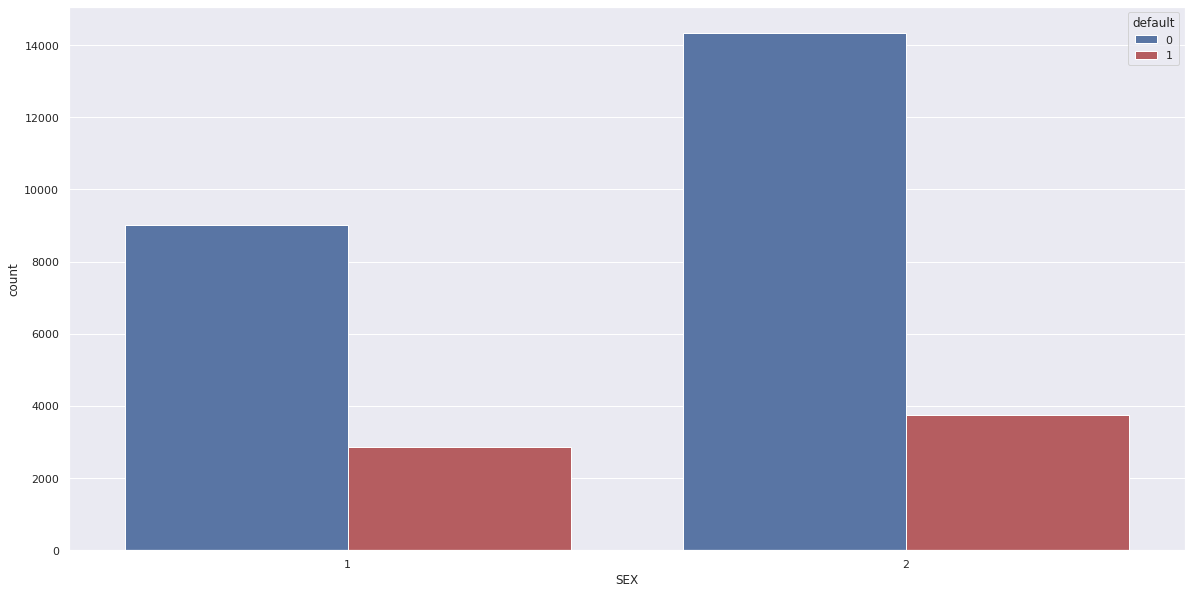

In [15]:
sns.countplot('SEX', hue='default', data=data, palette=['b', 'r']);

Видно, что женщин в обеих группах больше, чем мужчин, и отношение количества женщин к количеству мужчин в группе должников кажется чуть поменьше. Но в целом непонятно, сильно ли различие по гендерному составу, если оно вообще есть. 

Попробуем построить доверительные интервалы для отношения количества женщин к количеству мужчин в разных группах опять с помощью бутстрэпа.

In [16]:
# Возьмём бутстрэп выборки из разных групп и посчитаем количество женщин и мужчин в них
np.random.seed(42)
bootstrap_sex_debtor_counts = np.apply_along_axis(lambda x: np.unique(x, return_counts=True)[1],
                                                  axis=1, arr=get_bootstrap_samples(sex_debtor_data, 10000))

bootstrap_sex_paid_counts = np.apply_along_axis(lambda x: np.unique(x, return_counts=True)[1],
                                                axis=1, arr=get_bootstrap_samples(sex_paid_data, 10000))

In [17]:
# Считаем отношение количества женщин к количеству мужчин
f_m_debtor_ratio = bootstrap_sex_debtor_counts[:, 1] / bootstrap_sex_debtor_counts[:, 0]
f_m_paid_ratio = bootstrap_sex_paid_counts[:, 1] / bootstrap_sex_paid_counts[:, 0]

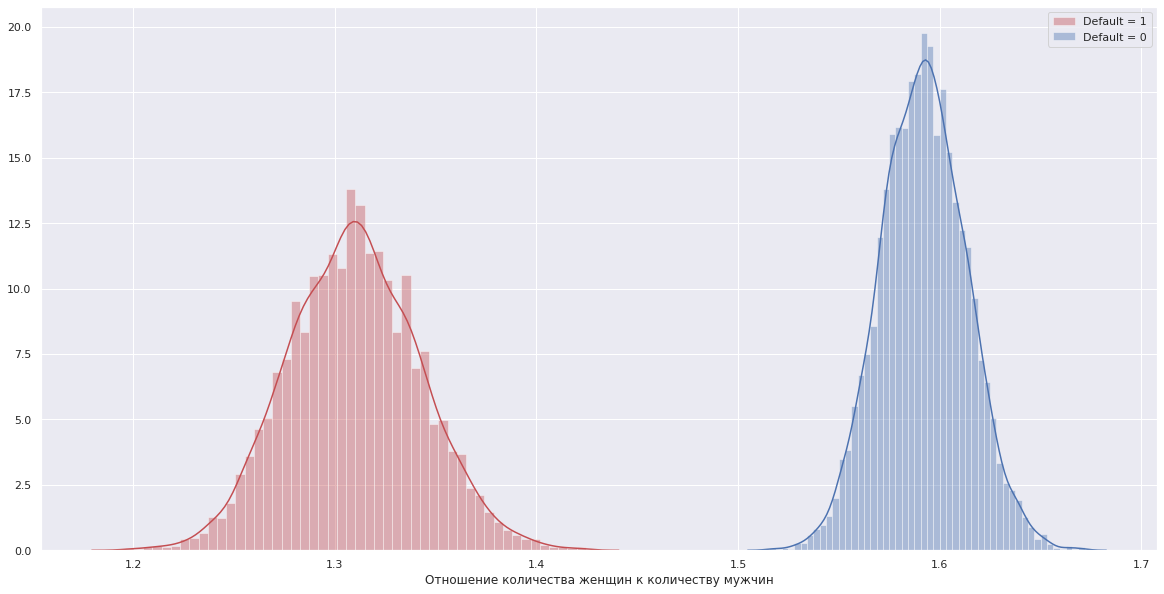

In [18]:
# Посмотрим на их распределения
sns.distplot(f_m_debtor_ratio, color='r', label='Default = 1')
sns.distplot(f_m_paid_ratio, color='b', label='Default = 0')
plt.xlabel('Отношение количества женщин к количеству мужчин')
plt.legend();

Распределения похожи на нормальные и видно, что они раздвинуты относительно друг друга, что может указывать на различие между гендерным составом в группах. Но давайте построим интервалы, чтобы это проверить.

In [19]:
# Построим отдельно интервалы для обеих групп на уровне значимости 0.05
print(f'95% доверительный интервал для отношения количества женщин к количеству мужчин в группе должников: \
{get_interval(f_m_debtor_ratio, alpha=0.05)}')

print(f'95% доверительный интервал для отношения количества женщин к количеству мужчин в группе вернувших кредит: \
{get_interval(f_m_paid_ratio, alpha=0.05)}')

# Построим интервал разности медиан
diff_ratio = f_m_paid_ratio - f_m_debtor_ratio
print(f'95% доверительный интервал для разности отношения количества женщин к количеству мужчин в двух группах: \
{get_interval(diff_ratio, alpha=0.05)}')

95% доверительный интервал для отношения количества женщин к количеству мужчин в группе должников: [1.24796748 1.37423971]
95% доверительный интервал для отношения количества женщин к количеству мужчин в группе вернувших кредит: [1.55121206 1.63464884]
95% доверительный интервал для разности отношения количества женщин к количеству мужчин в двух группах: [0.20610876 0.35748761]


Видим, что интервалы не пересекаются и доверительный интервал для разности не содержит нуля, поэтому можно сделать вывод о том, что гендерный состав групп статистически значимо различается на уровне значимости 0.05: отношение количества женщин к количеству мужчин в группе вернувших кредит в целом больше этого же отношения в группе должников.


Проверим теперь то же самое с помощью другого критерия. Наши рассматриваемые признаки категориальны, независимы и имеют достаточно большое количество наблюдений. Это даёт нам право на использование критерия хи-квадрат. Будем проверять нулевую гипотезу, что распределение по полу в группах никак не зависит от этой самой группы. Альтернативной гипотезой будет, что распределение в разных группах будет разное на уровне значимости 0.05.

In [20]:
# Построим таблицу сопряжённости для признаков пол и возврат\невозврат кредита
sdtable = pd.crosstab(index=data.default, columns=data.SEX)
sdtable

SEX,1,2
default,,
0,9015,14349
1,2873,3763


In [21]:
print(f'p-value для критерия хи-квадрат: {stats.chi2_contingency(sdtable.values)[1]}')

p-value для критерия хи-квадрат: 4.944678999412044e-12


Видно, что критерий хи-квадрат также уверенно отвергает нулевую гипотезу и даёт возможность сделать вывод, что распределение по гендерному признаку в рассматриваемых группах статистически значимо отличается.

**Задание 3.** 
Образование (EDUCATION): Проверьте гипотезу о том, что образование не влияет на то, вернет ли человек долг. Предложите способ наглядного представления разницы в ожидаемых и наблюдаемых значениях количества человек вернувших и не вернувших долг. Например, составьте таблицу сопряженности "образование" на "возврат долга", где значением ячейки была бы разность между наблюдаемым и ожидаемым количеством человек. Как бы вы предложили модифицировать таблицу так, чтобы привести значения ячеек к одному масштабу не потеряв в интерпретируемости ? Наличие какого образования является наилучшим индикатором того, что человек отдаст долг ? наоборт, не отдаст долг ? 

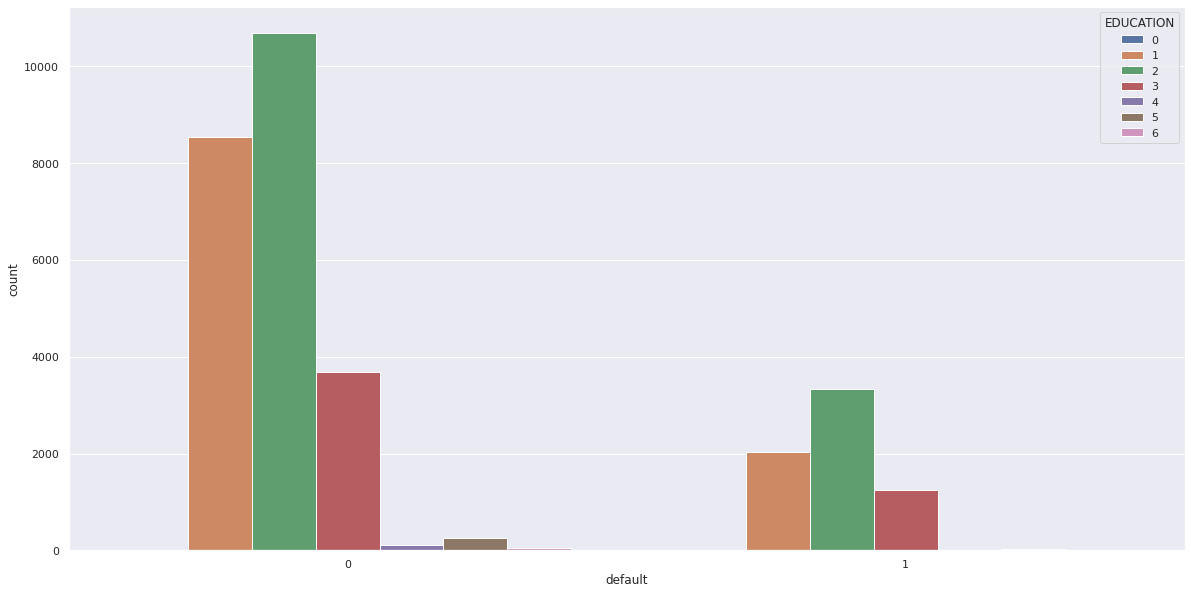

In [22]:
# Посмотрим на распределение
sns.countplot(data.default, hue=data.EDUCATION);

На графике похоже, что соотношение разного уровня образования в разных группах сохраняется, но с уверенностью сказать ничего нельзя. Рассматриваемые признаки категориальны, независимы и имеют достаточно большое количество наблюдений, следовательно, выполняются требования для применения критерия хи-квадрат. Проверим гипотезу о влиянии образования человека на возврат/невозврат долга с его помощью. Нулевая гипотеза: уровень образования не влияет на то, вернёт ли долг человек. Альтернативная: уровень образования каким-то образом влияет.

In [23]:
# Построим таблицу сопряжённости для признаков образования и возврата/невозврата кредита
edtable = pd.crosstab(index=data.default, columns=data.EDUCATION)
edtable

EDUCATION,0,1,2,3,4,5,6
default,,,,,,,
0,14,8549,10700,3680,116,262,43
1,0,2036,3330,1237,7,18,8


In [24]:
# Получим p-value для критерия хи-квадрат, а также таблицу ожидаемых значений
results = stats.chi2_contingency(edtable)
edtable_expected = pd.DataFrame(results[3])
print(f'p-value для критерия хи-квадрат: {results[1]}')

p-value для критерия хи-квадрат: 1.2332626245415605e-32


Полученный p-value позволяет отвергнуть нулевую гипотезу в пользу альтернативы, что уровень образования каким-то образом влияет на то, вернёт ли человек долг или нет. Посмотрим на таблицу ожидаемых значений, которую предоставляет нам критерий, а также на разность между наблюдаемыми и ожидаемыми значениями.

In [25]:
# Ожидаемое значение меньше 5 только в 1 из 14 ячеек, что меньше 20%, значит критерий можно было применить
edtable_expected

,0,1,2,3,4,5,6
0,10.9032,8243.598,10926.564,3829.3596,95.7924,218.064,39.7188
1,3.0968,2341.402,3103.436,1087.6404,27.2076,61.936,11.2812


In [26]:
# Построим таблицу сопряжённости, где в ячейках стоит разность между наблюдаемым и ожидаемым значением
edtable_diff = edtable - edtable_expected
edtable_diff

EDUCATION,0,1,2,3,4,5,6
default,,,,,,,
0,3.0968,305.402,-226.564,-149.3596,20.2076,43.936,3.2812
1,-3.0968,-305.402,226.564,149.3596,-20.2076,-43.936,-3.2812


Можно модифицировать значения в таблице путём деления значений каждого столбца на общее количество человек в данной группе и умножения на 100. Таким образом, ячейки будут показывать какой процент от числа человек определённого уровня образования составляет полученное отклонение.

In [27]:
mod_edtable_diff = (edtable_diff / edtable.sum(axis=0) * 100).round(2)
mod_edtable_diff

EDUCATION,0,1,2,3,4,5,6
default,,,,,,,
0,22.12,2.89,-1.61,-3.04,16.43,15.69,6.43
1,-22.12,-2.89,1.61,3.04,-16.43,-15.69,-6.43


Из этой таблицы можно увидеть, что ожидаемые значения должников на основе наших данных были больше наблюдаемых в 5 из 7 групп (0, 1, 4, 5, 6), а меньше только в 2 из 7 (2, 3). Наибольшее отклонение в 22.12% получилось в группе с уровнем образования "доктор", следовательно, можно ожидать, что, давая кредит человеку с таким уровнем образования, он его скорее всего вернёт. А вот люди с уровнем образования "выпускник школы" чаще долг не возвращают, так как в наших данных оказалось на 3.04% больше должников, чем ожидалось, если была бы верна нулевая гипотеза.

**Задание 4.** Семейное положение (MARRIAGE): Проверьте, как связан семейный статус с индикатором дефолта: нужно предложить меру, по которой можно измерить возможную связь этих переменных и посчитать ее значение.

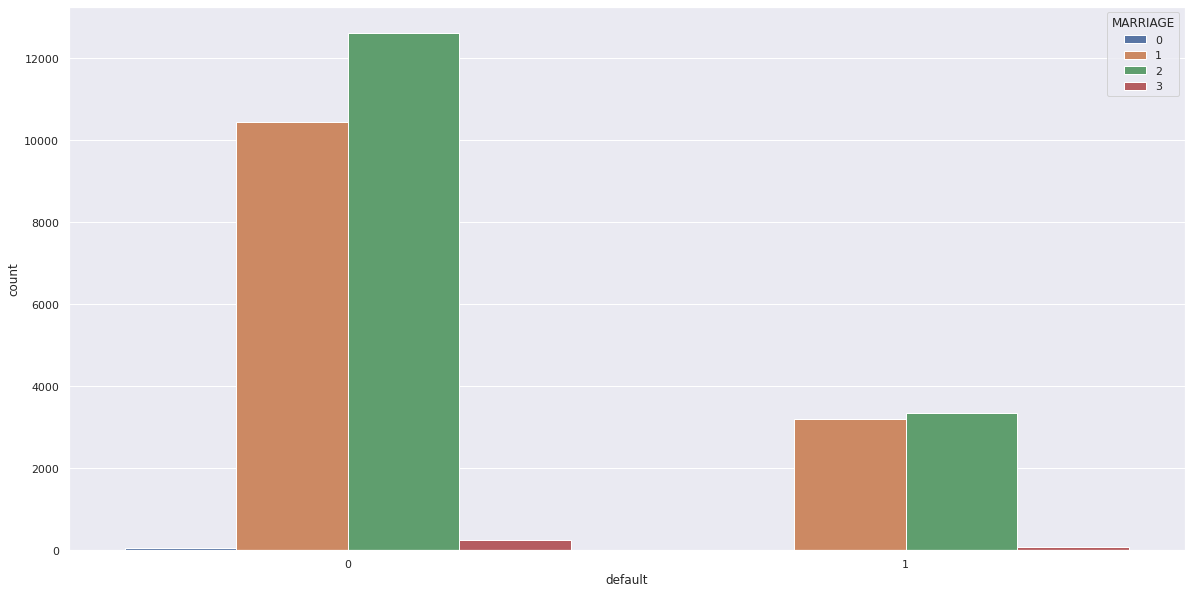

In [28]:
# Посмотрим на распределение
sns.countplot('default', hue='MARRIAGE', data=data);

Можно увидеть, что среди должников увеличивается доля замужних/женатых людей по отношению к остальным группам. Рассматриваемые признаки категориальны, независимы и имеют достаточно большое количество наблюдений, следовательно, выполняются требования для применения критерия хи-квадрат. Опять нулевой гипотезой будет отсутствие связи между маритальным статусом и невозвратом долга, а альтернативной наличие какой-либо связи.

In [29]:
# Построим таблицу сопряжённости
mdtable = pd.crosstab(index=data.default, columns=data.MARRIAGE)
mdtable

MARRIAGE,0,1,2,3
default,,,,
0,49,10453,12623,239
1,5,3206,3341,84


In [30]:
# Применим критерий хи-квадрат
print(f'p-value для критерия хи-квадрат: {stats.chi2_contingency(mdtable)[1]}') 

p-value для критерия хи-квадрат: 8.825862457577375e-08


Такое значение p-value позволяет уверенно отвергнуть нулевую гипотезу и сказать, что признаки каким-то образом связаны. Чтобы посмотреть на силу этой связи, можно посчитать коэффициент V Крамера.

In [31]:
def cramerv(table):
    chi2 = stats.chi2_contingency(table)[0]
    return np.sqrt(chi2 / (table.sum().sum() * (np.minimum(*table.shape) - 1)))

In [32]:
print(f'Коэффициент V Крамера для признаков MARRIAGE и default: {round(cramerv(mdtable), 4)}')

Коэффициент V Крамера для признаков MARRIAGE и default: 0.0345


Коэффициент V Крамера получился очень маленьким. Вряд ли такую связь можно считать практически значимой, хоть она и получилась статистически значимой. Скорее всего здесь очень сильно влияет то, что критерий хи-квадрат при больших выборках (а у нас она достаточно большая) склонен давать большое значение статистики при очень небольших отличиях, что приводит к статистической значимости.

**Задание 5.** Возраст (AGE): Относительно двух групп людей вернувших и не вернувших кредит проверьте следующие гипотезы: a) о равенстве медианных значений возрастов людей b) о равенстве распределений с помощью одного из подходящих непараметрических критериев проверки равенства средних. Значимы ли полученные результаты с практической точки зрения ?

In [33]:
age_debtor_data = data[data.default == 1].AGE
age_paid_data = data[data.default == 0].AGE

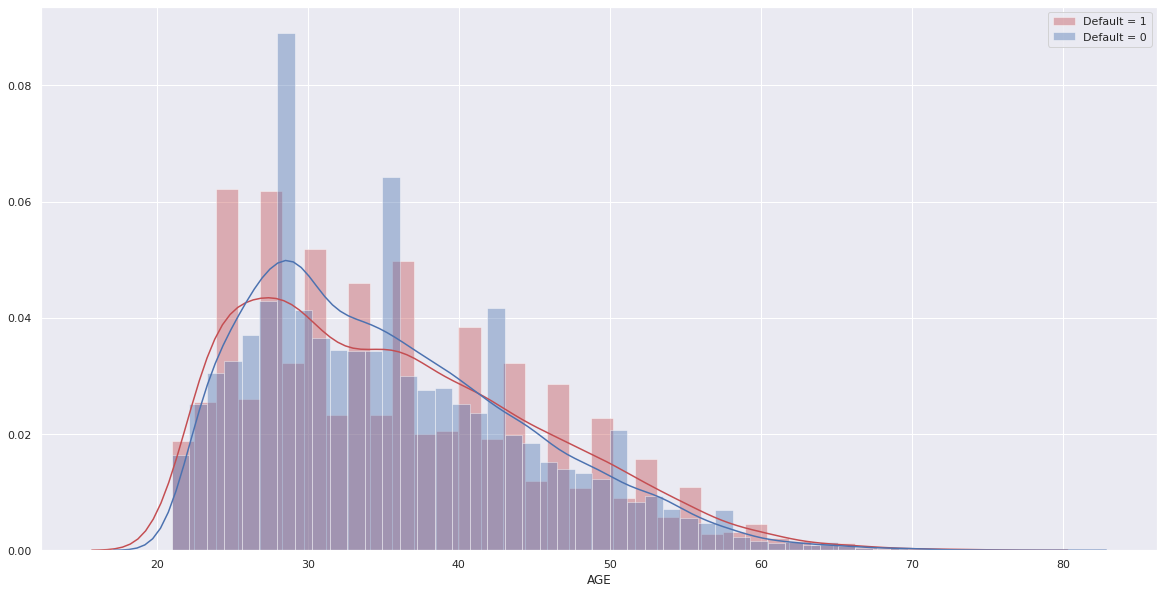

In [34]:
# Посмотрим распределение
sns.distplot(age_debtor_data, color='r', label='Default = 1')
sns.distplot(age_paid_data, color='b', label='Default = 0')
plt.legend();

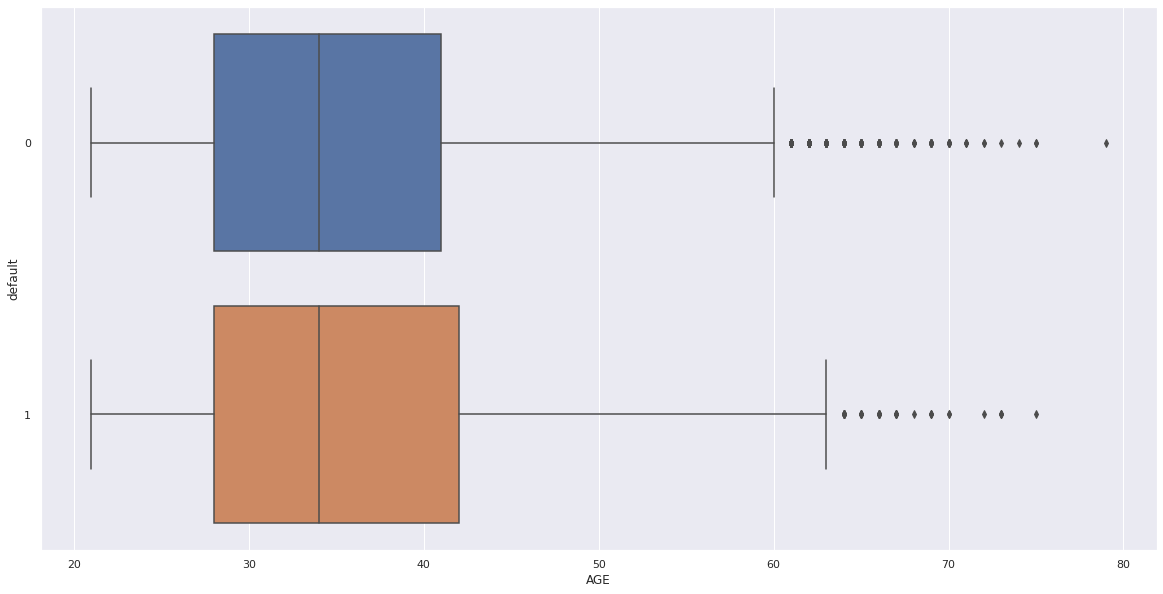

In [35]:
sns.boxplot(data.AGE, data.default, orient='h');

Из графика видно, что распределения почти одинаковые. Сложно вытащить отсюда какую-либо важную информацию. Попробуем получить информацию с помощью статистических критериев.

Сначала проверим нулевую гипотезу о равенстве медиан возраста в обеих группах против альтернативы, что медианы отличаются. Воспользуемся критерием Краскела-Уоллиса. Если выполняется предположение о  том, что все рассматриваемые группы имеют примерно одинаковую форму распределения и одинаковый масштаб, то можно проверить нулевую гипотезу о равенстве медиан этих распределений против альтернативы, что медианы различны. Из графиков можно видеть, что оба этих предположения выполняются. Также построим бутстрэп интервал для разности медиан, чтобы убедиться в результате критерия.

In [36]:
print(f'p-value для критерия Краскела-Уоллиса: {round(stats.kruskal(age_debtor_data, age_paid_data)[1], 4)}')

p-value для критерия Краскела-Уоллиса: 0.3725


In [37]:
print(f'95% доверительный интервал для разности медиан возраста двух групп: \
{get_interval(np.median(get_bootstrap_samples(age_paid_data, n_samples), axis=1) - \
             np.median(get_bootstrap_samples(age_debtor_data, n_samples), axis=1), alpha=0.05)}')

95% доверительный интервал для разности медиан возраста двух групп: [-1.  0.]


Полученный p-value не позволяет отклонить нулевую гипотезу, а доверительный интервал разности медиан содержит 0,поэтому мы не можем сказать, что медианы в рассматриваемых группах отличаются. Теперь воспользуемся критерием Манна-Уитни (выборки независимые) с нулевой гипотезой о равенстве распределений. проверять будем против альтернативы, что распределения различаются.

In [38]:
print(f'p-value для критерия Манна-Уитни: {round(stats.mannwhitneyu(age_debtor_data, age_paid_data)[1], 4)}')

p-value для критерия Манна-Уитни: 0.1863


Опять получили p-value, который не позволяет отвергнуть нулевую гипотезу. Судя по графикам и результатам статистических тестов, возможно, с практической точки зрения, при принятии решения выдачи кредита, на возраст стоит смотреть в последнюю очередь.